In [1]:
import pandas as pd
import os 

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import seaborn as sns
import numpy as np

from pytimekr import pytimekr

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
database = pd.read_csv('./data/electric_train_cp949.csv', encoding='cp949', index_col=0)
database['electric_train.tm'] = pd.to_datetime(database['electric_train.tm'])

print(database.shape)

(7593355, 16)


In [3]:
elec_cols = ['electric_train.'+ a for a in ['tm', 'hh24', 'weekday', 'week_name', 'sum_qctr', 'n', 'sum_load', 'n_mean_load', 'elec']]

weat_cols = ['electric_train.'+ a for a in ['num', 'stn', 'nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_rn_60m', 'nph_ta_chi']]

reset_order_cols = elec_cols + weat_cols

df_new = database[reset_order_cols]
colunms = {}
for col in reset_order_cols:
    colunms[col] = col.split('.')[1]

df_new = df_new.rename(columns=colunms)

df_new['year'] = df_new['tm'].dt.year
df_new['month'] = df_new['tm'].dt.month
df_new['day'] = df_new['tm'].dt.day
df_new = df_new.sort_values(by='tm')

# 시즌을 결정하는 함수
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# 'season' 컬럼 추가
df_new['season'] = df_new['tm'].dt.month.apply(get_season)
df_new['season'] = df_new['season'].map({'Spring':0, 'Summer':1, 'Fall':2, 'Winter':3})

df_new.head()

,tm,hh24,weekday,week_name,sum_qctr,n,sum_load,n_mean_load,elec,num,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,year,month,day,season
2647991,2020-01-01 01:00:00,1,2,0,63850,39,9732.96,250.490543,99.63,13615,140,-8.5,74.5,0.9,0.0,-5.8,2020,1,1,3
5208382,2020-01-01 01:00:00,1,2,0,14750,20,2401.12,116.010234,103.49,18235,565,-8.8,25.6,1.9,0.0,-4.6,2020,1,1,3
5182078,2020-01-01 01:00:00,1,2,0,71630,32,12139.16,363.252769,104.43,18234,565,-8.8,25.6,1.9,0.0,-4.6,2020,1,1,3
5155774,2020-01-01 01:00:00,1,2,0,45840,28,6723.84,225.924357,106.29,18233,512,-6.3,31.3,2.5,0.0,-7.8,2020,1,1,3
1280137,2020-01-01 01:00:00,1,2,0,76450,44,12949.24,287.250770,102.45,11272,941,2.4,68.0,1.2,0.0,-5.3,2020,1,1,3


### 공휴일은 주말로 표기

In [4]:
kr_holidays_2021 = pytimekr.holidays(year=2021)
kr_holidays_2022 = pytimekr.holidays(year=2022)
kr_holidays_2023 = pytimekr.holidays(year=2023)

df_new.loc[df_new['tm'].isin(kr_holidays_2021),'week_name']=1
df_new.loc[df_new['tm'].isin(kr_holidays_2022),'week_name']=1
df_new.loc[df_new['tm'].isin(kr_holidays_2023),'week_name']=1

### 시간의 연속성 추가

In [5]:
# ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
# ## sin cos 함수를 이용한 시간의 연속적 표현 (cyclical time encoding)
df_new['sin_time'] = np.sin(2*np.pi*df_new.hh24/24)
df_new['cos_time'] = np.cos(2*np.pi*df_new.hh24/24)

### THI(불쾌지수) & CDH(Cooling Degree Hour) 변수 추가

In [6]:
# 불쾌지수 
df_new['THI'] = 9/5*df_new['nph_ta'] - 0.55*(1-df_new['nph_hm']/100)*(9/5*df_new['nph_hm']-26)+32

In [7]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))        # 26도 
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

df_new['CDH'] = 0
cdhs = np.array([])
for num in df_new['num'].unique():                   # 격자별 불쾌지수 
    temp = df_new[df_new['num'] == num]
    cdh = CDH(temp['nph_ta'].values)
    df_new.loc[df_new['num'] == num, 'CDH'] = cdh

# df_new['CDH'] = CDH(df_new['nph_ta'].values)


In [8]:
cols_for_test = [
        'tm', 'year', 'season', 'month','day', 'hh24', 'weekday','week_name', 'sin_time', 'cos_time',
        'num',
        'stn', 'nph_ta','nph_hm', 'CDH', 'THI',
        'nph_ws_10m', 'nph_rn_60m', 'nph_ta_chi', 
       'elec']

df_train = df_new[cols_for_test]

df_train.head()
# weekday: 요일, weel_name: 주중, 주말

,tm,year,season,month,day,hh24,weekday,week_name,sin_time,cos_time,num,stn,nph_ta,nph_hm,CDH,THI,nph_ws_10m,nph_rn_60m,nph_ta_chi,elec
2647991,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,13615,140,-8.5,74.5,-34.5,1.538975,0.9,0.0,-5.8,99.63
5208382,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18235,565,-8.8,25.6,-34.8,7.943264,1.9,0.0,-4.6,103.49
5182078,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18234,565,-8.8,25.6,-34.8,7.943264,1.9,0.0,-4.6,104.43
5155774,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,18233,512,-6.3,31.3,-32.3,9.196031,2.5,0.0,-7.8,106.29
1280137,2020-01-01 01:00:00,2020,3,1,1,1,2,0,0.258819,0.965926,11272,941,2.4,68.0,-23.6,19.353600,1.2,0.0,-5.3,102.45


### 이상치 처리

In [9]:
# 온도별 elec의 이상치 처리 
for idx in list(df_train.loc[df_train['elec'] < 0, 'nph_ta'].index):
    area_num = df_train.loc[idx]['num']
    season = df_train.loc[idx]['season']
    year = df_train.loc[idx]['year']
    temp = df_train.loc[idx]['nph_ta']
    df_train.loc[idx, 'elec'] = \
        df_train.loc[(df_train.loc[idx]['num'] == area_num) & (df_train.loc[idx]['year'] == year) & (df_train.loc[idx]['season'] == season) & (df_train['nph_ta'] == temp), :]['elec'].mean()
        # 해당 지역의 해당 연도의 해당 시즌의 해당 온도와 같은 날의 elec의 평균

In [10]:
# 풍속이 음수인 값을 갖는 이상치 처리

ano_list = list(df_train.loc[df_train['nph_ws_10m'] < 0, 'nph_ws_10m'].index)
for idx in ano_list:
    pre_idx = idx - 1
    nex_idx = idx + 1

    previous_value = df_train.loc[pre_idx, 'nph_ws_10m']
    next_value = df_train.loc[nex_idx, 'nph_ws_10m']
    mean_val = (previous_value + next_value) / 2
    df_train.loc[idx, 'nph_ws_10m'] = mean_val

### EDA & Pre-Processing

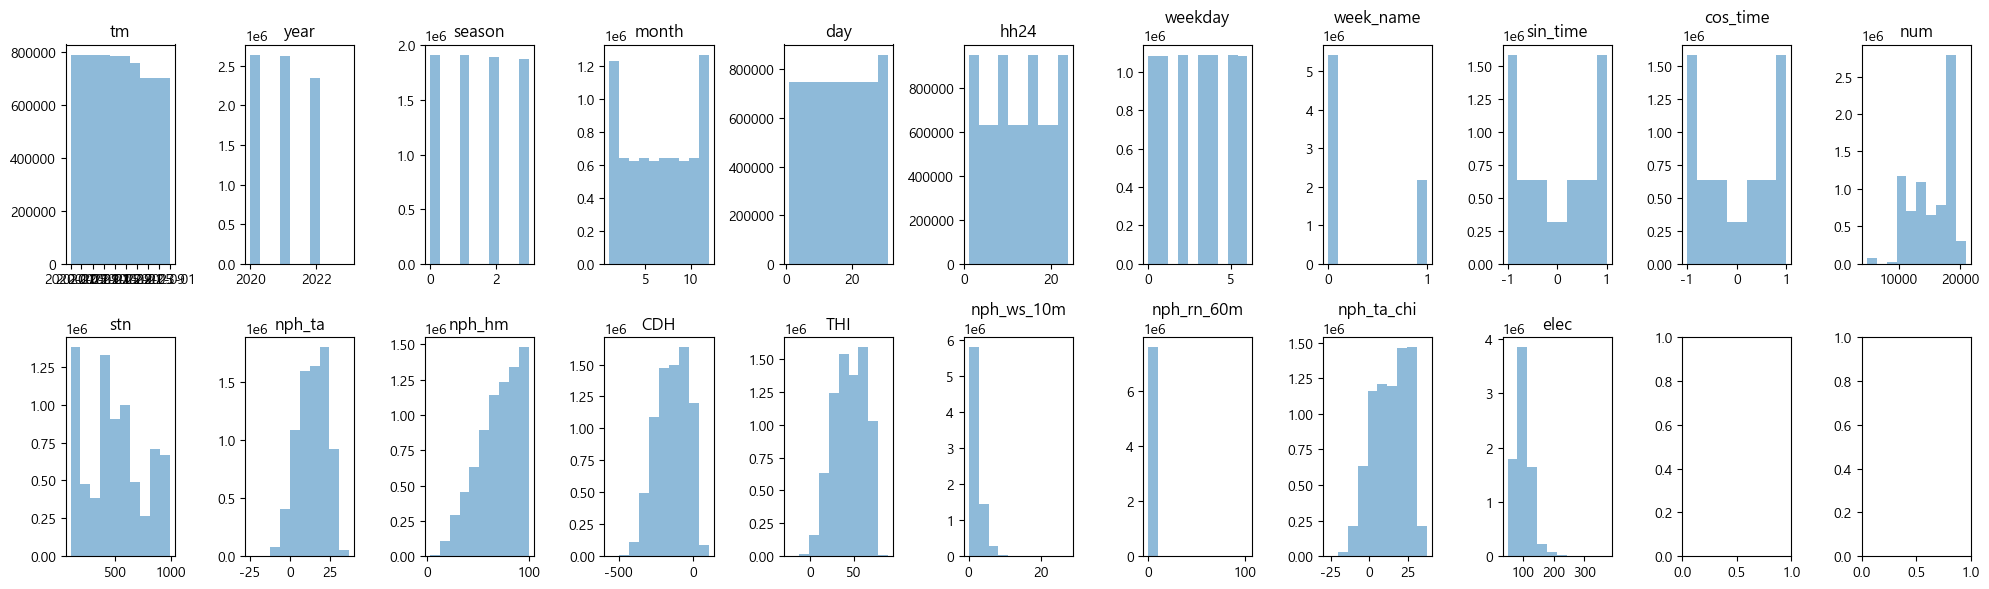

In [11]:
## plot feature data distribution

fig, ax = plt.subplots(2, df_train.shape[1]//2+1, figsize=(20, 6))
for idx, feature in enumerate(df_train.columns):
    data = df_train[feature]
    if idx<df_train.shape[1]//2 + 1:
        ax[0,idx].hist(df_train.iloc[:,idx], bins=10, alpha=0.5)
        ax[0,idx].set_title(df_train.columns[idx])
    else:
        ax[1,idx-df_train.shape[1]//2-1].hist(df_train.iloc[:,idx], bins=10, alpha=0.5)
        ax[1,idx-df_train.shape[1]//2-1].set_title(df_train.columns[idx])
        
plt.tight_layout()
plt.show()

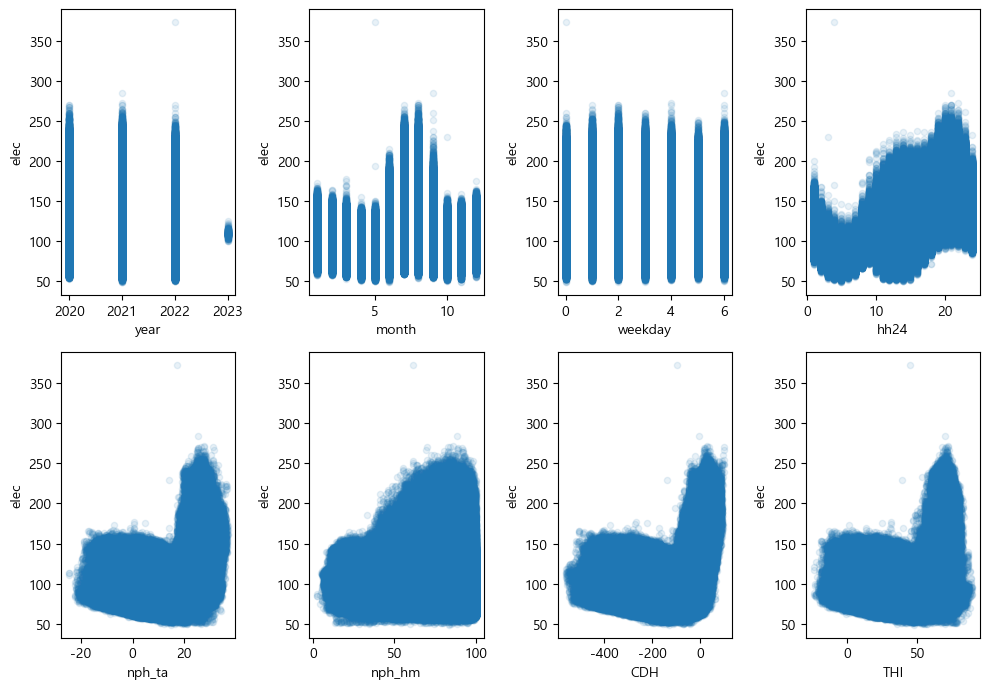

In [12]:
## chk feature correlation visually

fig, axes = plt.subplots(2, 4, figsize=(10,7))
df_train.plot(x='year', y='elec', kind='scatter', alpha=0.1, ax=axes[0,0])
df_train.plot(x='month', y='elec', kind='scatter', alpha=0.1, ax=axes[0,1])
df_train.plot(x='weekday', y='elec', kind='scatter', alpha=0.1, ax=axes[0,2])
df_train.plot(x='hh24', y='elec', kind='scatter', alpha=0.1, ax=axes[0,3])

df_train.plot(x='nph_ta', y='elec', kind='scatter', alpha=0.1, ax=axes[1,0])
df_train.plot(x='nph_hm', y='elec', kind='scatter', alpha=0.1, ax=axes[1,1])
df_train.plot(x='CDH', y='elec', kind='scatter', alpha=0.1, ax=axes[1,2])
df_train.plot(x='THI', y='elec', kind='scatter', alpha=0.1, ax=axes[1,3])

fig.tight_layout()

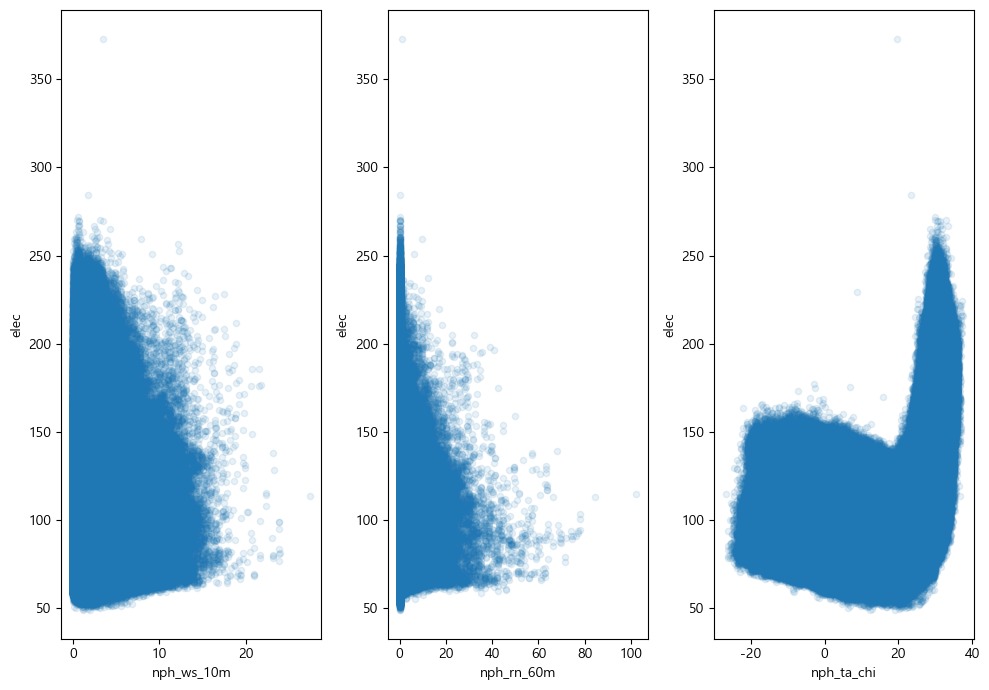

In [13]:
# 풍속, 강수량, 체감온도 
fig, axes = plt.subplots(1, 3, figsize=(10,7))
df_train.plot(x='nph_ws_10m', y='elec', kind='scatter', alpha=0.1, ax=axes[0])
df_train.plot(x='nph_rn_60m', y='elec', kind='scatter', alpha=0.1, ax=axes[1])
df_train.plot(x='nph_ta_chi', y='elec', kind='scatter', alpha=0.1, ax=axes[2])
fig.tight_layout()

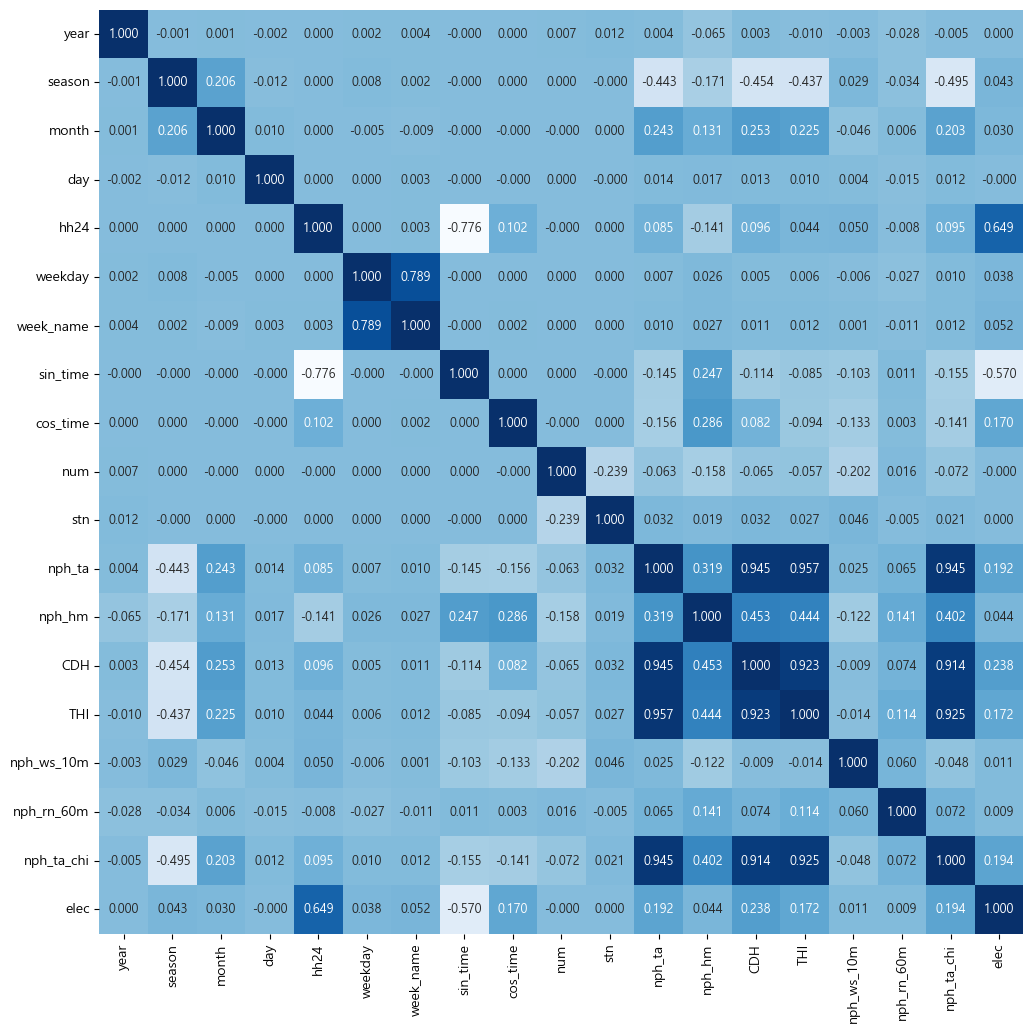

In [14]:
# 상관관계 시각화 
plt.figure(figsize=(12,12))
sns.heatmap(df_train.corr(numeric_only=True),
           annot=True,
           cmap='Blues',
           cbar=False, # 옆에 칼라 바 제거 
           square=True,
            fmt='.3f', # 소수점
            annot_kws={'size':9}
           )    
plt.show()

In [15]:
# day는 1일부터 28 또는 30 또는 31일을 갖는 컬럼으로 필요가 없어보인다. 
df_train.to_csv('./data/train_preprocessed.csv', index=False)

In [16]:
# import scipy.stats as spst
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# period = 7      # 요일별 (주중, 주말) 변화량이 느껴지니 7일씩의 트랜드를 알아보자 
# decomp = sm.tsa.seasonal_decompose(df_train['elec'], model = 'additive', period = period)
# result = pd.DataFrame({'tm':df_train.tm, 'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})


# result.head()

In [17]:
# import scipy.stats as spst
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# period = 7      # 요일별 (주중, 주말) 변화량이 느껴지니 7일씩의 트랜드를 알아보자 
# decomp = sm.tsa.seasonal_decompose(df_train['elec'], model = 'additive', period = period)

# for num in df_train['num'].unique():  
#     temp = df_train[df_train['num'] == num]
#     decomp = sm.tsa.seasonal_decompose(temp['elec'], model = 'additive', period = period)

#     result = pd.DataFrame({'tm':temp.tm, 'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
#     result['trend'] = result['trend'].ffill()
#     result['trend'] = result['trend'].bfill()
#     result['residual'] = result['residual'].ffill()
#     result['residual'] = result['residual'].bfill()
    
#     df_train

# result.head()

In [18]:
# # 트랜드와 잔차를 추가해보자 
# from tqdm import tqdm
# #######################################
# ## 건물별, 요일별, 시간별 전력기상지수 평균 넣어주기
# #######################################
# power_mean = pd.pivot_table(df_train, values = 'elec', index = ['num', 'hh24', 'weekday'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# df_train['weekday_hour_mean_elec'] = df_train.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hh24 == x['hh24']) & (power_mean.weekday == x['weekday']) ,'elec'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 전력기상지수 평균 넣어주기
# #######################################
# power_hour_mean = pd.pivot_table(df_train, values = 'elec', index = ['num', 'hh24'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# df_train['hour_mean_elec'] = df_train.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hh24 == x['hh24']) ,'elec'].values[0], axis = 1)

# #######################################
# ## 건물별 시간별 전력기상지수 표준편차 넣어주기
# #######################################
# power_hour_std = pd.pivot_table(df_train, values = 'elec', index = ['num', 'hh24'], aggfunc = np.std).reset_index()
# tqdm.pandas()
# df_train['hour_std_elec'] = df_train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hh24 == x['hh24']) ,'elec'].values[0], axis = 1)



elec의 트랜드를 넣으려고 했는데, test 데이터에서 어떠한 elec 관련 값이 주어지지 않기 때문에 위 features들을 만들어봐야 소용없다.